In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from sklearn.datasets import make_sparse_coded_signal
from scipy.linalg import polar
from tensorflow import keras
import pandas as pd
from scipy.stats import bernoulli
from scipy.sparse import csr_matrix
from sklearn.decomposition import SparseCoder
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.optimize import minimize, rosen, rosen_der
from scipy.sparse import random
from scipy.linalg import qr
from keras.datasets import mnist

Gradient Estimation Function

In [170]:
def grad_f(y,D):
  y = y.reshape((y.size,1))
  dd = np.multiply(np.absolute(np.dot(D.T, y)),np.dot(D.T,y))
  return -np.dot(y, dd.T)

Nonconvex Stochastic Frank Wolfe Algorithm

In [171]:
def noncvx_swf(y, D_0, T):
  G = 0 #initialize the gradient approximation variable
  D = []
  D.append(D_0) #add the initial D_0
  t = 1 #initizalize iteration count

  while t<=T: # give maximum number of iteration 
    p = 4*(np.power((t+1),(-1/2)))
    v = 2*(np.power((t+2),(-3/4)))

    #Gradient Approximation
    sum_grad = 0

    M = y[t-1].shape[1]
    for j in range(M):
      sum_grad += grad_f(y[t-1][:,j], D[t-1])

    G = ((1-p) * G) + ((p/M) * sum_grad)

    #LMO
    U, sigma, V_T = np.linalg.svd(-G)
    S = np.dot(U,V_T)

    #Variable Update
    D_upd = (1-v)*D[t-1] + v*S
    D_new = polar(D_upd)[0] #polar decomposition returns u and p
    D.append(D_new)

    t += 1 # increase iteration count
  return D

Stochastic Frank Wolfe Algorithm

In [172]:
def swf(y, D_0, T):
  D = []
  D.append(D_0)
  d = 0
  t = 1
  N = y[0].shape[0]
  v = ortho_group.rvs(dim = N)
  while t <= T: #give maximum number of iteration

    stepsize1 = 4*(np.power((t+1),(-1/2)))
    stepsize2 = 2*(np.power((t+3),(-3/4)))

    #Gradient Approximation
    sum_grad = 0
    M = y[t-1].shape[1]
    for j in range(M): 
      sum_grad += grad_f(y[t-1][:,j], D[t-1])

    d = (1-stepsize1)*d + stepsize1*sum_grad

    #LMO
    U, sigma, V_T = np.linalg.svd(-d)
    v = np.dot(U,V_T)
    
    #Variable Update
    D.append((1-stepsize2)*D[t-1] + stepsize2*v)
    
    t += 1
  return D

Function to calculate p^th power of the lp norm

In [173]:
def lp_4(D):
  sum =0
  for row in D:
    for col in row:
      sum += col**4
  return sum

# **Experience on the Senthetic Data Set**

Data Generation Function

In [ ]:
def generate_data(N=10, M=10, theta=0.3):
  y_all = []
  D_true_all = []
  x_all = []
  L = 100
  mu, sigma = 0, 0.1
  T = 3000

  for i in range(L):
    y_t_all = []
    H = np.random.rand(N,N)
    Q, R = qr(H)
    D_true = Q[:,0:N]
    
    for t in range(T):
      B = np.random.rand(N,M)
      B[B>theta] = 0
      B[B>0] = 1
      G = np.random.randn(N,M)
      x = np.multiply(B,G)
      y = np.dot(D_true,x)

      y_t_all.append(y)

    D_true_all.append(D_true)
    x_all.append(x)
    y_all.append(y_t_all)

  return D_true_all, y_all

Function for L Monte Carlo Trial which returns 3000 Dictionary for each algorithm

In [ ]:
def synthetic_montecarlo(y, N = 10,B = 10):
  T = 3*(10**3)
  D_nonconvex = []
  D_swf = []
  L = 100
  H = np.random.randn(N, N)
  D_0, R = qr(H)
  for i in range(L): 
    D1 = noncvx_swf(y[i], D_0, T)
    D_nonconvex.append(D1)

    D2 = swf(y[i],D_0, T)
    D_swf.append(D2)

  return D_nonconvex, D_swf

Error Calculation Function

In [ ]:
def synthetic_error(D, D_true, N = 10):
  T = 3*(10**3)
  L = 100
  error = []
  for t in range(T):
    sum = 0
    for l in range(L):
      D_mult = np.dot((D[l][t]).T, D_true[l])
      sum += np.absolute((1-lp_4(D_mult)/N))
    error.append(sum/L)
  return error

Plotting Graphs

In [ ]:
def plot_graphs(error_noncvx,error_swf,N = 10,B = 10,theta= 0.3):
  graph_x = np.array(range(0,3000))/1000
  a = [pow(10, -i) for i in range(4)]
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.set_yscale('log')
  plt.xlabel('Time Index t') 
  plt.ylabel('Eror_t') 
  ax.plot(graph_x, error_noncvx, color = 'r')
  ax.plot(graph_x, error_swf, color='g',)
  ax.legend(["noncvx_swf: N = {0:.1f}, B = {1:.1f}, θ = {2:.1f}".format(N,B,theta), 
              "swf: N = {0:.1f}, B = {1:.1f}, θ = {2:.1f}".format(N,B,theta)])

Now let's imply our algorithms by using different types of hyperparameters

In [ ]:
N = 10

In [ ]:
D_true_all, y = generate_data(N = 10) # Data generation

D_syn_noncvx, D_syn_swf = synthetic_montecarlo(y, N = 10) 
  
error_noncvx = synthetic_error(D_syn_noncvx, D_true_all, N = 10) #error calculation
error_swf = synthetic_error(D_syn_swf, D_true_all, N=10) #error calculation

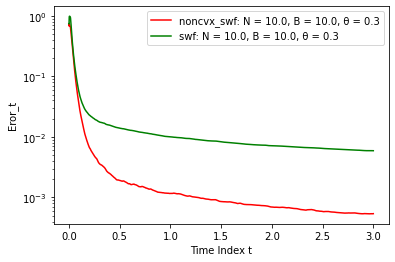

In [ ]:
plot_graphs(error_noncvx,error_swf,N = n)

In [ ]:
B = [1,10]

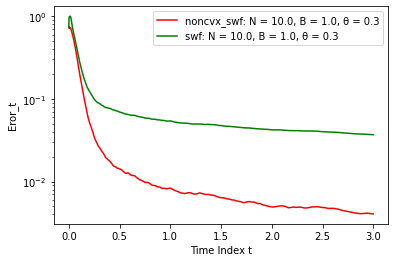

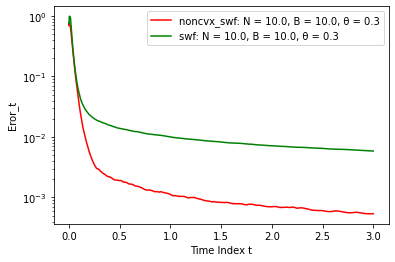

In [ ]:
for b in B:
  D_true_all, y = generate_data(M=b) # Data generation

  D_syn_noncvx,D_syn_swf = synthetic_montecarlo(y, B = b) #nonconvex_sfw
  error_noncvx = synthetic_error(D_syn_noncvx, D_true_all) #error calculation
  error_swf = synthetic_error(D_syn_swf, D_true_all) #error calculation

  plot_graphs(error_noncvx,error_swf,B = b) #plot both errors

In [ ]:
theta = [0.3, 0.5]

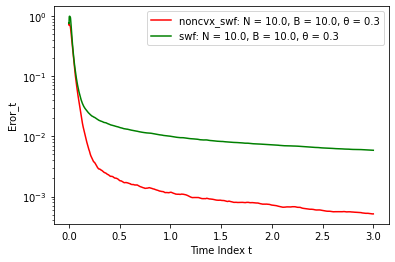

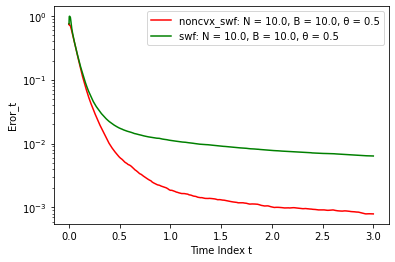

In [ ]:
for t in theta:
  D_true_all, y = generate_data(theta = t) # Data generation

  D_syn_noncvx, D_syn_swf = synthetic_montecarlo(y) #nonconvex_sfw
  error_noncvx = synthetic_error(D_syn_noncvx, D_true_all) #error calculation
  error_swf = synthetic_error(D_syn_swf, D_true_all) #error calculation

  plot_graphs(error_noncvx,error_swf,theta = t) #plot both errors

# **Experience on the Real World Datset**

We import MNIST dataset of handwritten digits which consists of 28x28 greyscale images

In [289]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

We take the first 1000 samples from it

In [290]:
train_X = train_X[:1000]

Let's reshape the 28x28 into 784

In [291]:
imgs_f = train_X.reshape((784,1000));

In [292]:
img_mean = np.mean(imgs_f,1).reshape(784,1)
img_var = np.var(imgs_f,0)[2]
imgs_f = (imgs_f - img_mean)

In [293]:
Y = imgs_f[:,0:1000]

Now we can create our minibatches which has length 10

In [294]:
Y_batched = []
k = 0
for i in range(1000):
  Y_batched.append(Y[:,k:k+10])
  k += 10

Function to calculate p^th power of lp norm of a vector

In [295]:
def lp_2(y):
  sum =0
  for y_i in y:
    sum += y_i**2
  return sum

Function to calculate D_true and sparse vector x

In [296]:
def sparse(D, y, n0):
  a = np.dot(D.T, y)
  l2_norms = [np.linalg.norm(ai) for ai in a]
  l2_norms_copy = l2_norms
  maximum_l2 = sorted(l2_norms)[:n0]
  index_max = [l2_norms_copy.index(m) for m in maximum_l2]
  for i in range(len(a)):
    if i in index_max:
      a[i] = 0
  return a

Root Mean Square Error for each t

In [297]:
def error_real(D,y_mini,T_i, mu = 28):
  rmse = []
  for t in range(T_i):
    sum_up = 0
    sum_down = 0
    M = y_mini[t].shape[1]
    for j in range(M):
      x_j = sparse(D[t], y_mini[t][:,j], mu)
      y_bar_j = np.dot(D[t],x_j)
      sum_up += (lp_2(y_bar_j - y_mini[t][:,j]))
      sum_down += (lp_2(y_mini[t][:,j]))
  rmse = np.sqrt(sum_up/(sum_down*T_i))
  return rmse*100

Now we can try our algorithm on the real world dataset with different size of compression ratios

In [298]:
H = np.random.randn(784, 784)
D_0, R = qr(H)
D_real_nswf = noncvx_swf(Y_batched, D_0, 100)
D_real_swf = swf(Y_batched, D_0, 100)

Let's try with different compression sizes

In [299]:
mu = [2, 7, 14, 28]

In [300]:
rmse_nonconvex = []
rmse_swf = []
for m in mu:
  rmse_nonconvex.append(error_real(D_real_nswf,Y_batched, 100, m))
  rmse_swf.append(error_real(D_real_swf,Y_batched, 100, m))

We can see the achieved rmse values

In [301]:
np.multiply(rmse_nonconvex,100)

array([0.19439973, 0.69037758, 1.78869138, 4.8277342 ])